In [26]:
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import os.path
import matplotlib.pyplot as plt
import scipy.interpolate
import re
import pdb

In [27]:
DIRNAME = "test_data/"

In [28]:
def get_line_spacing(baselines):
    #print(baselines)
    center_x = np.median([(l.T[0][0] + l.T[0][-1])/2 for l in baselines])
    
    center_ys = []
    for line in baselines:
        xs, ys = line.T
        center_ys.append(np.interp(center_x, xs, ys))

    med_spacing = np.median(np.diff(center_ys))
    return int(round(med_spacing))

def get_namespace(element):
    #rint(element.tag)
    m = re.match('\{.*\}', element.tag)
    return m.group(0)[1:-1] if m else ''    

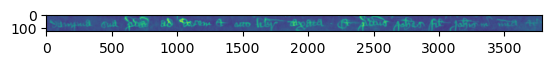

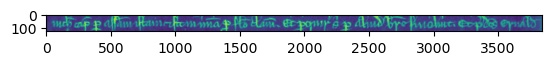

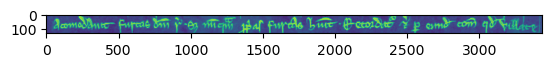

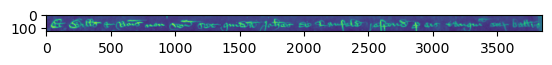

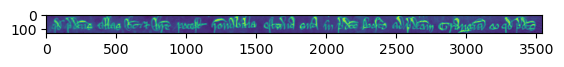

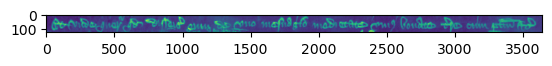

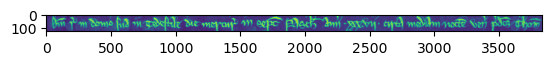

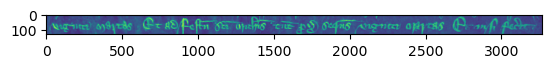

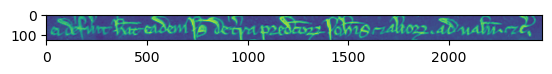

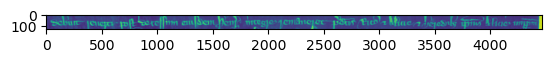

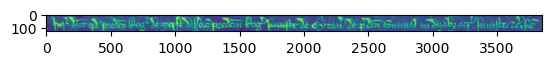

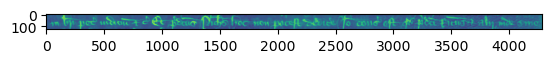

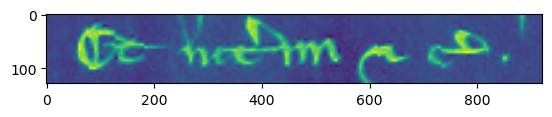

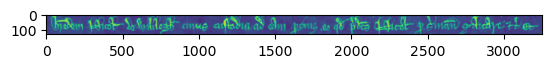

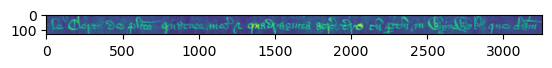

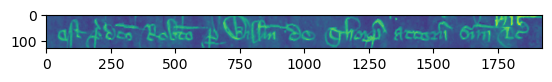

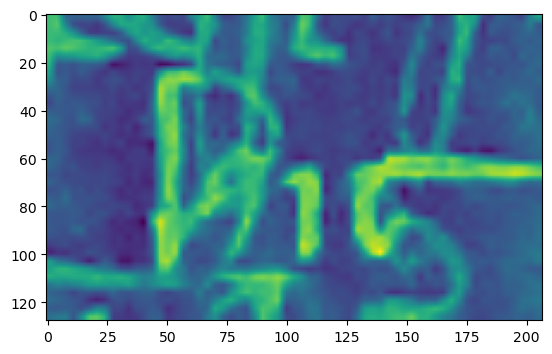

In [29]:
def subtract_bkd(image):
    bkd = np.percentile(image, 80, axis=0)
    cols = np.arange(image.shape[1])
    coeffs = np.polyfit(cols, bkd, 2)
    smoothed_bkd = np.polyval(coeffs, cols)
    new_image = np.copy(image) / smoothed_bkd * np.median(smoothed_bkd)
    return new_image

def extract_line_image(image_filename, output_filename, baseline, spacing, scaled_height=128, pad=10):
    baseline = np.unique(baseline, axis=0) #remove repeat points
    lower_spacing = int(round(0.23 * spacing))
    upper_spacing = int(round(0.77 * spacing))
    height = lower_spacing + upper_spacing
    
    image = cv2.imread(DIRNAME + image_filename, 0)
    xs, ys = baseline.T
    
    #Vertical pad everything to make the math easier
    top_pad = np.ones((spacing, image.shape[1])) * np.percentile(image[0:2], 80)
    bot_pad = np.ones((spacing, image.shape[1])) * np.percentile(image[-2:], 80)
    image = np.vstack((top_pad, image, bot_pad))
    ys += spacing
    
    dense_xs = np.arange(max(0, xs.min() - pad), 
                         min(image.shape[1]-1, xs.max() + pad))
    
    rectified = np.zeros((height, len(dense_xs)))
    dense_ys = scipy.interpolate.interp1d(xs, ys, bounds_error=False, kind="linear", fill_value="extrapolate")(dense_xs)
    #print(dense_xs.dtype, image.dtype)
    
    for i,x in enumerate(dense_xs):
        y_min = int(round(dense_ys[i] - upper_spacing))
        y_max = y_min + height
        rectified[:,i] = image[y_min:y_max, x]

    scaled_width = int(round(scaled_height / height * rectified.shape[1]))
    rectified = subtract_bkd(rectified)
    result = cv2.resize(rectified, (scaled_width, scaled_height), cv2.INTER_CUBIC)
    result = (np.median(result) - result) / (np.percentile(result, 90) - np.percentile(result, 10))
    
    cv2.imwrite(DIRNAME + output_filename, 255 * (result - result.min()) / (result.max() - result.min()))
        
    if np.random.randint(100) == 0:
        plt.figure()
        plt.imshow(result)
    np.save(output_filename.replace(".png", ".npy"), result)


for filename in glob.glob(DIRNAME + "*.xml"):
    baselines = []
    tree = ET.parse(filename)
    root = tree.getroot()
    ns = {"ns": get_namespace(tree.getroot())}
    ET.register_namespace('', ns['ns'])

    image_filename = root.find('ns:Page', ns).get('imageFilename')
    
    #First iteration: calculate average line spacing
    for text_region in root.findall('.//ns:TextRegion', ns):
        for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):
            baseline = text_line.find('ns:Baseline', ns).get('points')
            baselines.append(np.array([p.split(",") for p in baseline.split(" ")], dtype=int))
        
    med_spacing = get_line_spacing(baselines)

    #Second iteration: update bounding boxes
    for text_region in root.findall('.//ns:TextRegion', ns):
        for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):
            baseline = text_line.find('ns:Baseline', ns).get('points')          
            line_im_filename = "line_{}_{}".format(lineno, image_filename)
            line_im_filename, _ = os.path.splitext(line_im_filename)
            line_im_filename += ".png"
            extract_line_image(image_filename, line_im_filename, baselines[lineno], med_spacing)